In [1]:
# load data 
import pandas as pd
df = pd.read_csv('coffee_sales.csv')

In [3]:
df.head()

,hour_of_day,cash_type,money,coffee_name,Time_of_Day,Weekday,Month_name,Weekdaysort,Monthsort,Date,Time
0,10,card,38.7,Latte,Morning,Fri,Mar,5,3,2024-03-01,10:15:50.520000
1,12,card,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,2024-03-01,12:19:22.539000
2,12,card,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,2024-03-01,12:20:18.089000
3,13,card,28.9,Americano,Afternoon,Fri,Mar,5,3,2024-03-01,13:46:33.006000
4,13,card,38.7,Latte,Afternoon,Fri,Mar,5,3,2024-03-01,13:48:14.626000


In [ ]:
# Aggregate to get number of coffees sold (traffic) by hour, coffee type, and weekday
traffic = df.groupby(["hour_of_day", "coffee_name", "Weekday"]).size().reset_index(name="num_sales")

In [6]:
# Encode categorical columns manually (we’ll do this without sklearn)
# Map weekdays and coffee names to numeric indices
traffic["Weekday_encoded"] = traffic["Weekday"].astype("category").cat.codes
traffic["Coffee_encoded"] = traffic["coffee_name"].astype("category").cat.codes

In [7]:
# Define features (X) and target (y)
X = traffic[["hour_of_day", "Weekday_encoded", "Coffee_encoded"]].values
y = traffic["num_sales"].values

In [9]:
# Split into train/test (manually, 80/20)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("✅ Data ready")
print("Train shape:", X_train.shape, "Target shape:", y_train.shape)

✅ Data ready
Train shape: (616, 3) Target shape: (616,)


In [10]:
import numpy as np

class TreeNode:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index   # index of feature to split on
        self.threshold = threshold           # threshold value for split
        self.left = left                     # left child TreeNode
        self.right = right                   # right child TreeNode
        self.value = value                   # prediction at leaf (mean of targets)

class SimpleDecisionTreeRegressor:
    def __init__(self, max_depth=5, min_samples_split=10, min_impurity_decrease=1e-7):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_impurity_decrease = min_impurity_decrease
        self.root = None

    # Public fit method
    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y).reshape(-1,)
        self.n_features_ = X.shape[1]
        self.root = self._build_tree(X, y, depth=0)

    # Internal recursive tree builder
    def _build_tree(self, X, y, depth):
        n_samples, n_features = X.shape
        current_value = y.mean()

        # Stopping conditions
        if (depth >= self.max_depth) or (n_samples < self.min_samples_split) or np.all(y == y[0]):
            return TreeNode(value=current_value)

        best_feat, best_thresh, best_impurity = None, None, np.inf
        current_mse = self._mse(y)

        # Loop through features and possible thresholds
        for feature_index in range(n_features):
            Xi = X[:, feature_index]
            # candidate thresholds: midpoints between sorted unique feature values
            unique_vals = np.unique(Xi)
            if unique_vals.shape[0] == 1:
                continue
            thresholds = (unique_vals[:-1] + unique_vals[1:]) / 2.0

            for thresh in thresholds:
                left_mask = Xi <= thresh
                right_mask = Xi > thresh
                if left_mask.sum() < self.min_samples_split or right_mask.sum() < self.min_samples_split:
                    continue

                y_left, y_right = y[left_mask], y[right_mask]
                impurity = (y_left.size * self._mse(y_left) + y_right.size * self._mse(y_right)) / n_samples

                if impurity < best_impurity:
                    best_impurity = impurity
                    best_feat = feature_index
                    best_thresh = thresh

        # Check if we found a useful split
        if best_feat is None:
            return TreeNode(value=current_value)

        impurity_decrease = current_mse - best_impurity
        if impurity_decrease < self.min_impurity_decrease:
            return TreeNode(value=current_value)

        # Build children recursively
        left_mask = X[:, best_feat] <= best_thresh
        right_mask = ~left_mask

        left_node = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_node = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return TreeNode(feature_index=best_feat, threshold=best_thresh, left=left_node, right=right_node)

    # Predict single sample by traversing tree
    def _predict_one(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature_index] <= node.threshold:
            return self._predict_one(x, node.left)
        else:
            return self._predict_one(x, node.right)

    # Predict multiple samples
    def predict(self, X):
        X = np.asarray(X)
        preds = np.array([self._predict_one(x, self.root) for x in X])
        return preds

    # Mean squared error helper
    def _mse(self, y):
        if y.size == 0:
            return 0.0
        mu = y.mean()
        return np.mean((y - mu) ** 2)

    # Simple score (R^2) for convenience
    def score(self, X, y):
        y = np.asarray(y).reshape(-1,)
        preds = self.predict(X)
        ss_res = np.sum((y - preds) ** 2)
        ss_tot = np.sum((y - y.mean()) ** 2)
        return 1 - ss_res / ss_tot if ss_tot > 0 else 0.0

In [11]:
tree = SimpleDecisionTreeRegressor(max_depth=6, min_samples_split=8)

In [13]:
tree.fit(X_train, y_train)

In [14]:
y_pred_train = tree.predict(X_train)
y_pred_test = tree.predict(X_test)

In [16]:
# Evaluate
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

print("Train RMSE:", rmse(y_train, y_pred_train))
print("Test RMSE:", rmse(y_test, y_pred_test))
print("Test R2:", tree.score(X_test, y_test))

Train RMSE: 2.4126438106106187
Test RMSE: 3.104041015714816
Test R2: -0.0635624787437723


In [17]:
import matplotlib.pyplot as plt

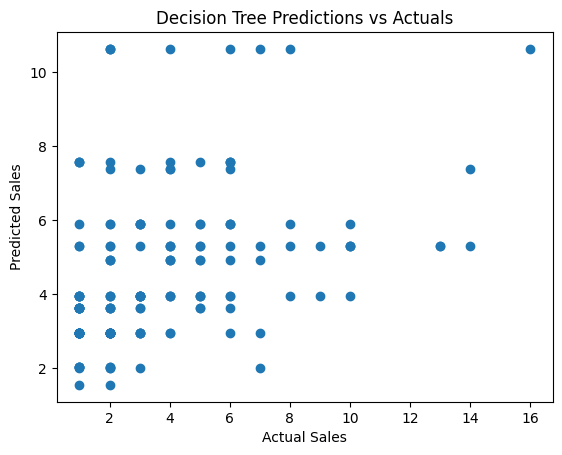

In [22]:
# visualize predictions vs actuals
plt.scatter(y_test, y_pred_test)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Decision Tree Predictions vs Actuals")
plt.show()